In [1]:
#!pip install packaging
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from packaging import version
import time

assert(version.parse(tf.__version__) >= version.parse("2.0.0-aplha"))

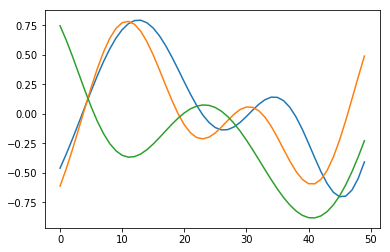

In [2]:
def generate_serie(size, step) :
    maxT = size*step
    t = np.arange(0, maxT, step)
#    return (np.sin(t+np.cos(t*0.31))).astype(np.float32)
    return (np.sin(t+np.sin(t*.31)) * np.sin(t / 3.3485)).astype(np.float32)
#    return (np.sin(t+np.cos(t)) + .34158*np.sin(t * 3.3485)).astype(np.float32)
#return (t * np.sin(t)/maxT + .3*np.sin(t * 3.3)).astype(np.float32)

def split(arr, *count) :
    total = sum(count)
    p0 = 0
    for i in count :
        p1 = p0 + i
        yield arr[int(len(arr)*p0/total):int(len(arr)*p1/total)]
        p0 = p1
    
    
np.random.seed(42)

N_STEPS = n_steps = 50
data = generate_serie(14001, .18)
data = [(data[i:i+n_steps], data[i+1:i+n_steps+1]) for i in range(len(data)-n_steps-1)] 
np.random.shuffle(data)

#plt.plot(data[1][0])
#plt.plot(data[2][0])
#plt.plot(data[3][0])
#plt.show()

spt_data = np.reshape([data[i][0] for i in range(len(data))], (-1, n_steps, 1))
spt_lbl = np.reshape([data[i][1] for i in range(len(data))], (-1, n_steps, 1))

train_size = 80
valid_size = 15
test_size = 5

[train, valid, test] = zip(split(spt_data, train_size, valid_size, test_size), 
                           split(spt_lbl, train_size, valid_size, test_size))

plt.plot(train[0][1])
plt.plot(train[0][2])
plt.plot(train[0][3])
plt.show()


In [3]:
class Encoder(tf.keras.Model):
  def __init__(self, hidden1, enc_units, batch_sz) : #, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.hidden1 = hidden1
    self.enc_units = enc_units
    self.batch_sz = batch_sz
    #self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    #self.inputi = tf.keras.Input(shape=(1,))
    #self.input_shape = tf.TensorShape([None,1])
    self.lstm = tf.keras.layers.LSTM(self.enc_units,
                                    return_sequences=True,
                                    #return_state=True,
                                    stateful=True,
                                    #activation="selu",
                                    #activation="linear",
                                    #recurrent_activation="selu",  
                                    recurrent_initializer='glorot_uniform')
    self.dense = tf.keras.layers.Dense(self.enc_units,
                                    activation="linear")

    #self.gru = tf.keras.layers.RNN(
    #    tf.keras.layers.GRUCell(self.enc_units,
    #                               recurrent_initializer='glorot_uniform'),
    #   return_sequences=True,
    #   return_state=True
    #)
    
  def call(self, x, initial_state=None): #, hidden):
    #print(x, initial_state)
    #x2 = self.inputi(x)
    #print(x2)
    if (initial_state!=None) :
        self.lstm.reset_states(initial_state)
    
    #output = self.lstm(x) #, initial_state = hidden)
    x = self.lstm(x) #, initial_state = hidden)
    output = self.dense(x)
    #output, self.state = self.lstm(x, self.state) #, initial_state = hidden)
    return output #, state

  #def reset_states(self) :
  #  self.lstm.reset_states()

  def reset_states(self, initial_state=None) :
    #print(self.lstm.input_spec)
    self.lstm.reset_states(initial_state)

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))
 

In [13]:
BATCH_SIZE = 8
EPOCHS = 4

encoder = Encoder(10, N_STEPS, BATCH_SIZE)
encoder.build(tf.TensorShape([BATCH_SIZE, None, 1]))
encoder.summary()
encoder.compile(optimizer="Adam", loss="MSE")
#print(len(train[0]))
#print(len(train[0])//BATCH_SIZE)
#print(len(train[0])//BATCH_SIZE*BATCH_SIZE)
#print(len(valid[0]))
#print(len(valid[0])//BATCH_SIZE)
#print(len(valid[0])//BATCH_SIZE*BATCH_SIZE)
tbs = len(train[0])//BATCH_SIZE*BATCH_SIZE
vbs = len(valid[0])//BATCH_SIZE*BATCH_SIZE
history = encoder.fit(train[0][:tbs], train[1][:tbs], epochs=EPOCHS, validation_data=(valid[0][:vbs], valid[1][:vbs]), batch_size=BATCH_SIZE)


Model: "encoder_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
unified_lstm_2 (UnifiedLSTM) multiple                  10400     
_________________________________________________________________
dense_2 (Dense)              multiple                  2550      
Total params: 12,950
Trainable params: 12,950
Non-trainable params: 0
_________________________________________________________________
Train on 11160 samples, validate on 2088 samples
Epoch 1/4
11120/11160 [============================>.] - ETA: 0s - loss: 0.0145

ValueError: Cannot create an execution function which is comprised of elements from multiple graphs.

dict_keys(['loss'])


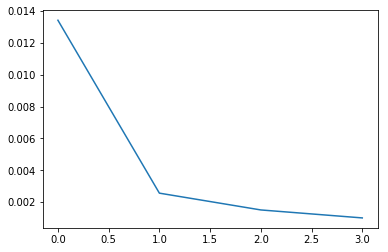

In [12]:
#print(history)
#print(history.history)
print(history.history.keys())

plt.plot(history.history['loss'], label="loss")
plt.show()